In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Total Model Simulation
This simulation takes into account position size, cost of rebalce fees, the approximate apr and is run over 10,000 synthetic histories.

The strategy creates a market neutral but short volatility position by created an LP position of ETH-USD while also maintaining a short of ETH that is equal to 50% of the total LP position size. This position will loses value whenever the price moves. It loses the same amount for a given log price move whether that move was up or down. Thus is position is market neutral but short volatility.

In order to maintain this market (delta) neutrality the position needs to be constantly rebalanced. Rebalancing of a hedged LP position will lock in the loses due to IL. There will also be loses associated with the cost of the rebalance which include gas costs, protocol fees, slippage and swap fees.

The aim of this analyses is to estimate the total cost of holding ths position over time. LP positions should only be created when the return, through swap fees and incentives, is higher than the cost of the position.

# Simulation Function
This function runs the simulation of the strategy and computes the total loss/gain incurred through rebalancing and LP returns for each bootstrapped return series.

In [9]:
def getSimValue(bootstraprets, position_size, rebalance_fee, swap_fee, fee_dapr, leverage, threshold):
    """
    This function runs the rebalancing strategy and tracks the total value of the position
    over time for each bootstrapped sample series.
    
    :param bootstraprets: An array of the bootstrapped returns series
    :param position_size: Size of the position in denominator (e.g. USD)
    :param rebalance_fee: Cost of the rebalance including gas in denominator
    :param swap_fee: Percentage fee taken from the swap protocol, should include expected loss due to slippage
    :param fee_dapr: The expected daily percentage return of LP position
    :param leverage: The leverage of the position
    :param threshold: the percentage price deviation required to rebalance the position
    """
    
    sample = pd.DataFrame(bootstraprets.iloc[:,:])+1
    acc_sample = pd.DataFrame(bootstraprets.iloc[:,:])+1
    position_val = pd.DataFrame(bootstraprets.iloc[:,:])+1
    daily_lp = pd.DataFrame(fee_dapr+sample**0.5)
    end_days = len(bootstraprets)-1

    # the simulated position value using pos size and fees
    # interate and cumprod until reach above threshold
    for sim in sample.columns:
        current_pos = position_size

        for day in sample.index:
            if np.abs(acc_sample.iloc[day,sim]-1) < threshold: 
                '''If accumulating product is below threshold then you keep accumulating the returns.
                Position value becomes the previous day value multiplied by the LP value'''
                lp_value = daily_lp.iloc[day,sim] # value of lev lp
                daily_debt = acc_sample.iloc[day,sim] + acc_sample.iloc[day,sim]*0.5*(leverage-2) + 0.5*(leverage-2) # debt from leverage pos
                daily_comb = lp_value*leverage - daily_debt
                position_val.iloc[day,sim] = daily_comb*current_pos
                if day != end_days:
                    acc_sample.iloc[day+1,sim]= acc_sample.iloc[day+1,sim]*acc_sample.iloc[day,sim] # keep track of returns
                    daily_lp.iloc[day+1,sim]= daily_lp.iloc[day+1,sim]*daily_lp.iloc[day,sim] # keep track of accumulating lp value w/apr
            else:
                '''When the threshold is above you rebalance the position and reset the counter.'''
                # acc_sample.iloc[day] the accumulated return is started again as
                lp_value = daily_lp.iloc[day,sim] # value of lev lp
                daily_debt = acc_sample.iloc[day,sim] + acc_sample.iloc[day,sim]*0.5*(leverage-2) + 0.5*(leverage-2) # debt from leverage pos
                daily_trade = np.abs((acc_sample.iloc[day,sim]-1)*0.5*(leverage)*swap_fee)  # trading fee to rebalance
                daily_comb = lp_value*leverage - daily_debt - np.abs(daily_trade)
                position_val.iloc[day,sim] = daily_comb*current_pos - rebalance_fee # current position value including gas fees to rebalance
                current_pos = position_val.iloc[day,sim] # after rebalance update current position value
    position_val=position_val/position_size # normalize position value
    return position_val

# Simulating Threshold Rebalancing Strategy

Below the simulations will be carried out on the bootstrapped and stationary bootstrapped returns series to see the expected return of the strategy on the ETH-USD pair.

In [10]:
# First we must load of the data
data = pd.read_pickle('ethusd_2017.pkl')
bs_historic = pd.read_pickle('bootstraprets_ethusd_365days.pkl')
bs_stationary = pd.read_pickle('stationarybootstraprets_ethusd_365days.pkl')

# Historic Bootstrapped Simulations
The non-stationary bootstraped return series will be simulated twice first looking at the cost of the rebalancing strategy given 0% expected APR of the LP position.

The second simulation test will run a 3x leverage position assuming a 20% expected APR.

$ 10000  position and  10.0 % thresh
$ 0.5  rebalance fee and 0.4% trading fee
APR =  0 %
1 x leverage


NameError: name 'median_return' is not defined

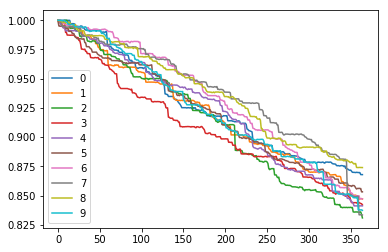

In [11]:
bootstraprets = bs_historic
position_size = 10000
rebalance_fee = 0.50
swap_fee = 0.004
fee_dapr = 0
leverage = 1
threshold = 0.1

position_val = getSimValue(bootstraprets, position_size, rebalance_fee, swap_fee, fee_dapr, leverage, threshold)

position_val.iloc[:,0:10].plot()
print('$',position_size,' position and ',threshold*100,'% thresh')
print('$',rebalance_fee,' rebalance fee and 0.4% trading fee')
print('APR = ',int(fee_dapr*36500),'%')
print(leverage,'x leverage')
ending_wealth = position_val.iloc[-1,:] # look at the ending wealth of strategy
cagr = median_return**(1/len(bootstraprets))
print('Average ending wealth: ',ending_wealth.mean())
print('Median ending wealth: ',ending_wealth.median())
print('5th quantile ending wealth: ',np.percentile(ending_wealth, .05))
print('CAGR: ',cagr) 
print('Effective APR: ',(cagr-1)*365)

$ 10000  position and  10.0 % thresh
$ 0.5  rebalance fee and 0.4% trading fee
APR =  0 %
1 x leverage
Average ending wealth:  0.8553025452215491
Median ending wealth:  0.8569140523388133
5th quantile ending wealth:  0.7757978869677602
CAGR:  0.9995770274112886
Effective APR:  -0.1543849948796533


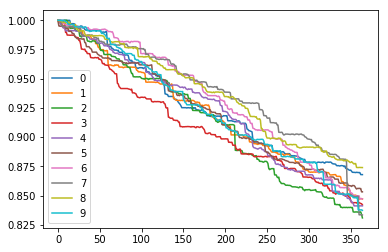

In [12]:
position_val.iloc[:,0:10].plot()
print('$',position_size,' position and ',threshold*100,'% thresh')
print('$',rebalance_fee,' rebalance fee and 0.4% trading fee')
print('APR = ',int(fee_dapr*36500),'%')
print(leverage,'x leverage')
ending_wealth = position_val.iloc[-1,:] # look at the ending wealth of strategy
cagr = (ending_wealth.median())**(1/len(bootstraprets))
print('Average ending wealth: ',ending_wealth.mean())
print('Median ending wealth: ',ending_wealth.median())
print('5th quantile ending wealth: ',np.percentile(ending_wealth, .05))
print('CAGR: ',cagr) 
print('Effective APR: ',(cagr-1)*365)

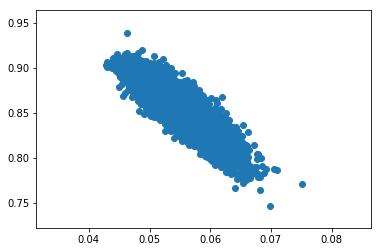

In [13]:
plt.scatter(np.std(bootstraprets),ending_wealth)

$ 10000  position and  10.0 % thresh
$ 0.5  rebalance fee and 0.4% trading fee
APR =  20 %
3 x leverage
Average ending wealth:  1.1537331642444715
Median ending wealth:  1.1587454875683316
5th quantile ending wealth:  0.8481078953908687
CAGR:  1.0004037470830085
Effective APR:  0.14736768529810207


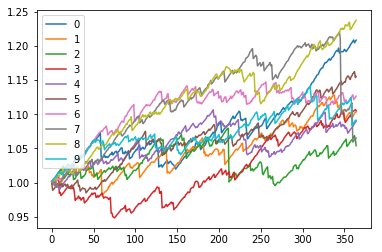

In [14]:
fee_dapr = 0.2/365
leverage = 3

position_val = getSimValue(bootstraprets, position_size, rebalance_fee, swap_fee, fee_dapr, leverage, threshold)

position_val.iloc[:,0:10].plot()
print('$',position_size,' position and ',threshold*100,'% thresh')
print('$',rebalance_fee,' rebalance fee and 0.4% trading fee')
print('APR = ',int(fee_dapr*36500),'%')
print(leverage,'x leverage')
ending_wealth = position_val.iloc[-1,:] # look at the ending wealth of strategy
cagr = (ending_wealth.median())**(1/len(bootstraprets))
print('Average ending wealth: ',ending_wealth.mean())
print('Median ending wealth: ',ending_wealth.median())
print('5th quantile ending wealth: ',np.percentile(ending_wealth, .05))
print('CAGR: ',cagr) 
print('Effective APR: ',(cagr-1)*365)

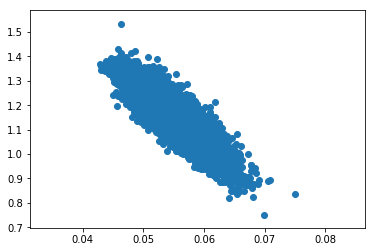

In [15]:
plt.scatter(np.std(bootstraprets),ending_wealth)

# Stationary Bootstrapped Simulations
The stationary bootstraped return series will be simulated twice first looking at the cost of the rebalancing strategy given 0% expected APR of the LP position.

The second simulation test will run a 3x leverage position assuming a 20% expected APR.

$ 10000  position and  10.0 % thresh
$ 0.5  rebalance fee and 0.4% trading fee
APR =  0 %
1 x leverage
Average ending wealth:  0.856172343236612
Median ending wealth:  0.8577225171291558
5th quantile ending wealth:  0.7695088176214889
CAGR:  0.99957960992728
Effective APR:  -0.15344237654279613


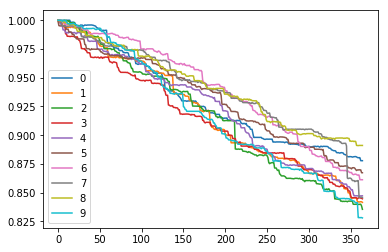

In [16]:
bootstraprets = bs_stationary
position_size = 10000
rebalance_fee = 0.50
swap_fee = 0.004
fee_dapr = 0
leverage = 1
threshold = 0.1

position_val = getSimValue(bootstraprets, position_size, rebalance_fee, swap_fee, fee_dapr, leverage, threshold)

position_val.iloc[:,0:10].plot()
print('$',position_size,' position and ',threshold*100,'% thresh')
print('$',rebalance_fee,' rebalance fee and 0.4% trading fee')
print('APR = ',int(fee_dapr*36500),'%')
print(leverage,'x leverage')
ending_wealth = position_val.iloc[-1,:] # look at the ending wealth of strategy
cagr = (ending_wealth.median())**(1/len(bootstraprets))
print('Average ending wealth: ',ending_wealth.mean())
print('Median ending wealth: ',ending_wealth.median())
print('5th quantile ending wealth: ',np.percentile(ending_wealth, .05))
print('CAGR: ',cagr) 
print('Effective APR: ',(cagr-1)*365)

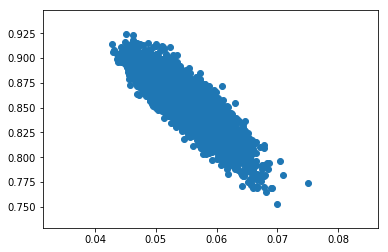

In [17]:
plt.scatter(np.std(bootstraprets),ending_wealth)

$ 10000  position and  10.0 % thresh
$ 0.5  rebalance fee and 0.4% trading fee
APR =  20 %
3 x leverage
Average ending wealth:  1.152247681218426
Median ending wealth:  1.1572176672979824
5th quantile ending wealth:  0.8299205946218124
CAGR:  1.0004001308838488
Effective APR:  0.1460477726048215


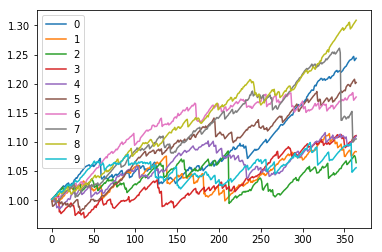

In [18]:
fee_dapr = 0.2/365
leverage = 3

position_val = getSimValue(bootstraprets, position_size, rebalance_fee, swap_fee, fee_dapr, leverage, threshold)

position_val.iloc[:,0:10].plot()
print('$',position_size,' position and ',threshold*100,'% thresh')
print('$',rebalance_fee,' rebalance fee and 0.4% trading fee')
print('APR = ',int(fee_dapr*36500),'%')
print(leverage,'x leverage')
ending_wealth = position_val.iloc[-1,:] # look at the ending wealth of strategy
cagr = (ending_wealth.median())**(1/len(bootstraprets))
print('Average ending wealth: ',ending_wealth.mean())
print('Median ending wealth: ',ending_wealth.median())
print('5th quantile ending wealth: ',np.percentile(ending_wealth, .05))
print('CAGR: ',cagr) 
print('Effective APR: ',(cagr-1)*365)

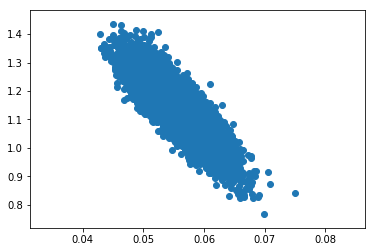

In [19]:
plt.scatter(np.std(bootstraprets),ending_wealth)